In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from mne.decoding import ReceptiveField
import pickle
import numpy as np
import  modin.pandas as pd
import os
from tqdm import tqdm
from NRC import NRC,recordModule
from matplotlib.pyplot import MultipleLocator
from matplotlib.gridspec import GridSpec
from utils import returnSpec
from distributed import Client
client = Client()

## 数据导入
可以选择导入 *exp* 文件夹中的‘EEG’，’TRF‘，或者’stimulus'文件。文件都是按照pickle格式存储。因为将所有的数据都汇总到一起，所以数据的读写时间会比较长。

### TRFs

In [3]:
TRFs = []
add = 'results/offline'
subs = os.listdir(add)

for sub in subs:
    subFolder = add+os.sep+sub 
    f = pd.read_csv(subFolder+os.sep+'TRF.csv')
    TRFs.append(f)

TRFs = pd.concat(TRFs,ignore_index=True)
TRFs.head()

,Unnamed: 0,channel,lags,trf,condition,feauture,subject,type,tag
0,0,PZ,-0.2,0.791411,19,0,shinanlin,locked,wn
1,1,PO5,-0.2,0.423860,19,0,shinanlin,locked,wn
2,2,POZ,-0.2,0.790817,19,0,shinanlin,locked,wn
3,3,PO4,-0.2,0.858917,19,0,shinanlin,locked,wn
4,4,PO6,-0.2,0.762472,19,0,shinanlin,locked,wn


TRF的frame中
1. channel 代表通道标签
2. lags代表延迟的时间轴
3. trf代表TRF的幅度
4. condition是trigger标记，1-20是whitenoise;20-40是m-seq；40-60是ssvep
5. type代表TRF有没有被正则化：whitened代表正则化，unwhitened是纯互相关
6. tag是刺激类型：白噪声，ssvep和mseq

### EEGs

In [ ]:
EEGs = []
add = 'results/exp-2'
subs = os.listdir(add)

for sub in subs:
    subFolder = add+os.sep+sub 
    f = pd.read_csv(subFolder+os.sep+'EEG.csv')
    EEGs.append(f)

EEGs = pd.concat(EEGs,ignore_index=True)
# TRFs = TRFs.loc[TRFs.subject!='diode']
EEGs.head()

### stimulus

In [ ]:
sti = []
add = 'results/exp-2'
subs = os.listdir(add)

for sub in subs:
    subFolder = add+os.sep+sub 
    f = pd.read_csv(subFolder+os.sep+'stimulus.csv')
    sti.append(f)

sti = pd.concat(sti,ignore_index=True).drop_duplicates()
# TRFs = TRFs.loc[TRFs.subject!='diode']
sti.head()

### performance

In [2]:
scores = []
add = 'results/exp-2'
subs = os.listdir(add)

for sub in subs:
    subFolder = add+os.sep+sub 
    f = pd.read_csv(subFolder+os.sep+'classification.csv')
    scores.append(f)

scores = pd.concat(scores,ignore_index=True).drop_duplicates()
scores = scores.loc[scores.subject!='diode']
scores.head()

FileNotFoundError: [Errno 2] No such file or directory: 'results/exp-2'

### Spectral

In [ ]:
spectral = []
add = 'results/exp-2'
subs = os.listdir(add)

for sub in subs:
    subFolder = add+os.sep+sub 
    f = pd.read_csv(subFolder+os.sep+'spectral.csv')
    spectral.append(f)

spectral = pd.concat(spectral,ignore_index=True).drop_duplicates()
spectral = spectral.loc[spectral.subject!='diode']
spectral.head()

# *Image 1* : TRF for different stimulus under subject average level

所有的分析，都可以用groupby这个函数，把一部分数据抽取出来。具体用法查看pandas官网

In [ ]:
ave = TRFs[(TRFs.subject!='diode')][['trf','lags','tag']].groupby(by=['tag', 'lags'],as_index=False).mean()
ave.head()

In [ ]:
aveTRF = ave[(ave.tag != 'ssvep') & (ave.lags <= 1)].groupby(['lags'],as_index=False).mean()
aveTRF = aveTRF['trf'].to_numpy()
f,t,Sxx = returnSpec(aveTRF)

In [ ]:
plt.rcParams['text.usetex'] = True
fig,(ax2,ax1) = plt.subplots(nrows=2,ncols=1,figsize=(10,6),gridspec_kw={'height_ratios': [2, 3]})

sns.set_theme(style='white')

plt.subplots_adjust(hspace=0.3)

sns.lineplot(data=ave[(ave.tag != 'ssvep') & (ave.lags <= 1)], x='lags',
             y='trf', hue='tag', palette=['#00239CFF', '#E10600FF'], linewidth=2, style='tag', ax=ax1)

# ax.set_ylim(-0.4,0.4)

ax1.vlines(x=0,ymin=-.4,ymax=.4,linestyles='dashed')
ax1.text(x=0.01,y=-.3,s='onset',fontsize=15)
ax1.set_xlabel(r'lag(s)')
ax1.set_ylabel(r'amplitude(a.u)')

ax1.legend(loc='upper left')

ax2.pcolormesh(t, f, Sxx, shading='gouraud', cmap='vlag',alpha=0.7)
ax2.set_ylim(0,50)
ax2.set_xlabel(r'lag(s)')
ax2.set_ylabel(r'frequency(Hz)')

ax2.set_xticklabels('')
ax2.set_xlabel('')

sns.despine()

# plt.savefig('./results/pics/AveTRF.png', dpi=200, format='png')

# *Image 2* : TRF for each person

In [ ]:
subTRFs = TRFs.groupby(by=['subject','tag','lags'],as_index=False).mean()
subTRFs.head()

在seaborn 中输入“hue”，就可以按照标签分类做图

In [ ]:
plt.rcParams['text.usetex'] = True

subjects = TRFs.subject.unique()

fig, axs = plt.subplots(ncols=2, nrows=len(subjects), figsize=(10, 10))

sns.set_theme(style='white')

for subINX,sub in enumerate(subjects):
    ax1,ax2 = axs[subINX]

    s = subTRFs[((subTRFs.tag!='ssvep'))&(subTRFs.subject==sub)&(subTRFs.lags<0.5)]
    sns.lineplot(data=s,x='lags',y='trf',hue='tag',palette=['#00239CFF', '#E10600FF'],linewidth=2.5,ax=ax1,legend=False)
    ax1.set_title('%s'%sub)

    ax1.vlines(x=0, ymin=-.5, ymax=.5, linestyles='dashed')
    ax1.set_xlabel(r'lag(s)')
    ax1.set_ylabel(r'amplitude(a.u)')

    s_ = s[['lags', 'trf', 'tag']].groupby(['lags'], as_index=False).mean()['trf'].to_numpy()
    f,t,Sxx = returnSpec(s_)
    ax2.pcolormesh(t-0.2, f, Sxx, shading='gouraud', cmap='vlag', alpha=0.7)

    ax2.set_ylim(0, 50)
    ax2.set_xlabel(r'lag(s)')
    ax2.set_ylabel(r'frequency(Hz)')

plt.tight_layout()
sns.despine()
# plt.savefig('./results/pics/subjects.png', dpi=200, format='png')

# *Image 3* : Spatial Propogation

In [ ]:
TRFs.channel.unique()

In [ ]:
TRFs.subject.unique()

In [ ]:
chnNames = ['OZ','O1','PO3','PO7','P7','PO4','PO8','PO4']
# chnNames = ['CB1','OZ','POZ','PZ','CPZ']
# chnNames = ['OZ', 'O1', 'PO7', 'P7', 'TP7']
# chnNames = ['OZ', 'O2', 'PO8', 'P8', 'TP8']
# chnNames = ['PO7', 'PO3', 'POZ', 'PO4', 'PO8']

# chnNames = ['P7', 'P5', 'P3', 'P1', 'PZ', 'P2', 'P4', 'P6', 'P8']

travel = TRFs[(TRFs.channel.isin(chnNames))].groupby(by=['channel','tag','lags','subject'],as_index=False).mean()
travelAve = TRFs[(TRFs.channel.isin(chnNames))&(TRFs.subject!='diode')].groupby(by=['channel','tag','lags'],as_index=False).mean()
travelAve.head()

## white noise

In [ ]:
plt.rcParams['text.usetex'] = True
f, (ax1,ax2) = plt.subplots(figsize=(10, 8), ncols=1, nrows=2)

sns.set_theme(style='white')
plt.subplots_adjust(hspace=0.3)

sns.lineplot(data=travelAve[(travelAve.tag == 'ssvep') & (travelAve.lags < 0.5) & (
    travelAve.lags > -0.1)], x='lags', y='trf', palette='husl', linewidth=2.5, hue='channel', ax=ax1, hue_order=chnNames)

sns.lineplot(data=travel[(travel.tag == 'ssvep') & (travel.subject == 'shinanlin') & (travel.lags < 0.5) & (
    travel.lags > -0.1)], x='lags', y='trf', palette='husl', linewidth=2.5, hue='channel', ax=ax2, hue_order=chnNames,legend=False)

# ax1.vlines(x=0, ymin=-1, ymax=1, linestyles='dashed')

# ax.text(x=0.01, y=-.3, s='onset', fontsize=15)

ax1.set_xlabel(r'lag(s)')
ax1.set_ylabel(r'amplitude(a.u)')
ax1.set_title('Phase propogation on average')
ax2.set_title('Phase propogation on a representative subject')

ax2.set_xlabel(r'lag(s)')
ax2.set_ylabel(r'amplitude(a.u)')

sns.despine()
# plt.savefig('./results/pics/propogate_PO7-PO8.svg', dpi=200, format='svg')

## mseq

In [ ]:
plt.rcParams['text.usetex'] = True
f, (ax1,ax2) = plt.subplots(figsize=(10, 8), ncols=1, nrows=2)

sns.set_theme(style='white')
plt.subplots_adjust(hspace=0.3)

sns.lineplot(data=travelAve[(travelAve.tag == 'mseq') & (travelAve.lags < 0.5) & (
    travelAve.lags > -0.1)], x='lags', y='trf', palette='husl', linewidth=2.5, hue='channel', ax=ax1, hue_order=chnNames)

sns.lineplot(data=travel[(travel.tag == 'mseq') & (travel.subject == 'shinanlin') & (travel.lags < 0.5) & (
    travel.lags > -0.1)], x='lags', y='trf', palette='husl', linewidth=2.5, hue='channel', ax=ax2, hue_order=chnNames,legend=False)


# ax.text(x=0.01, y=-.3, s='onset', fontsize=15)

ax1.set_xlabel(r'lag(s)')
ax1.set_ylabel(r'amplitude(a.u)')
ax1.set_title('Phase propogation on average')
ax2.set_title('Phase propogation on a representative subject')

ax2.set_xlabel(r'lag(s)')
ax2.set_ylabel(r'amplitude(a.u)')

sns.despine()
# plt.savefig('./results/pics/propogate_PO7-PO8.svg', dpi=200, format='svg')

## ssvep

In [ ]:
plt.rcParams['text.usetex'] = True
f, (ax1, ax2) = plt.subplots(figsize=(14, 10), ncols=1, nrows=2)

sns.set_theme(style='white')

sns.lineplot(data=travel[(travel.tag == 'ssvep') & (travel.subject != 'diode') & (travel.lags < 0.5) & (
    travel.lags > -0.1)], x='lags', y='trf', palette='husl', linewidth=2, hue='channel', ax=ax1)


sns.lineplot(data=travel[(travel.tag == 'mseq') & (travel.subject == 'guoxiaolei') & (travel.lags < 0.5) & (travel.lags > -0.1)], x='lags', y='trf', palette='husl', linewidth=2, hue='channel', ax=ax2)

ax.vlines(x=0, ymin=-1, ymax=1, linestyles='dashed')

# ax.text(x=0.01, y=-.3, s='onset', fontsize=15)
ax.set_xlabel(r'lag(s)')
ax.set_ylabel(r'amplitude(a.u)')
ax1.set_title('Phase propogation on average')
ax2.set_title('Phase propogation on a representative subject')
sns.despine()
# plt.savefig('./results/pics/propogate_mseq.svg', dpi=200, format='svg')

# *Image 4*: mTRF

In [ ]:
chnNames = ['OZ','O1','PO3','PO7','P7','PO4','PO8','PO4']

ssvepTRFs = TRFs[(TRFs.channel.isin(chnNames)) & (TRFs.subject != 'diosde') & (TRFs.tag == 'ssvep')].groupby(by=['condition', 'subject', 'lags'], as_index=False).mean()


allTRFs = TRFs[(TRFs.channel.isin(chnNames)) & (TRFs.subject != 'diode')].groupby(by=['tag', 'subject', 'lags'], as_index=False).mean()
allTRFs.head()

In [ ]:
ssvepAve = ssvepTRFs.pivot_table(index='condition',columns='lags',values='trf')
ssvepAve.head()

In [ ]:
ave = TRFs[((TRFs.channel.isin(chnNames)))][['trf','channel', 'lags', 'tag','subject']].groupby(by=['tag', 'lags', 'subject'], as_index=False).mean()
ave.head()

In [ ]:
plt.rcParams['text.usetex'] = True

dpi = 150
fig = plt.figure(figsize=(1000/dpi, 1000/dpi),dpi=dpi)


spec = fig.add_gridspec(4, 4)

ax1 = fig.add_subplot(spec[0, :])
ax2 = fig.add_subplot(spec[1:, :])


# sns.lineplot(data=ssvepTRFs[ssvepTRFs.subject==sub],x='lags',y='trf',ax=ax1,linewidth=3)
sns.lineplot(data=allTRFs, x='lags', y='trf',
             ax=ax1, linewidth=2, hue='tag', style='tag', palette=['#DA291CFF','#56A8CBFF', '#53A567FF'], style_order=['ssvep', 'mseq', 'wn'],hue_order=['ssvep', 'mseq', 'wn'])


t = ssvepAve.columns.to_numpy()
f = ssvepAve.index.to_numpy()
Z = ssvepAve.to_numpy()

# ax2.pcolormesh(t,f[::-1],Z,shading='gouraud', cmap='vlag',vmin=Z.min(), vmax=Z.max(),snap=True)

ax2.imshow(ssvepAve.to_numpy(), cmap='vlag',aspect='auto', interpolation='antialiased')
ax2.yaxis.set_major_locator(MultipleLocator(2))
ax2.yaxis.set_ticklabels([r"%.1f" % i for i in np.arange(7, 19, 1)])


ax1.set_xlabel(r'lags(s)')
ax2.set_xlabel(r'lags(s)')

ax2.set_ylabel(r'Frequency(Hz)')
ax1.set_ylabel(r'Amplitude(a.u)')

ax1.set_title('subject average')
ax1.legend(loc='upper left')
plt.tight_layout()

plt.savefig('./results/pics/aveSSVEP_TRFs.png', dpi=fig.dpi, format='png')

In [ ]:
sub = 'huangfeixiang'
ssvepSub = ssvepTRFs[ssvepTRFs.subject==sub].pivot_table(index='condition',columns='lags',values='trf')
ssvepSub.head()

In [ ]:
plt.rcParams['text.usetex'] = True
dpi = 150
fig = plt.figure(figsize=(1000/dpi, 1000/dpi),dpi=dpi)

sns.set_theme(style='white')

spec = fig.add_gridspec(4, 4)

ax1 = fig.add_subplot(spec[0, :])
ax2 = fig.add_subplot(spec[1:, :])

# sns.lineplot(data=ssvepTRFs[ssvepTRFs.subject==sub],x='lags',y='trf',ax=ax1,linewidth=3)
sns.lineplot(data=ave[(ave.subject == sub)], x='lags', y='trf',
             ax=ax1, linewidth=2, hue='tag', style='tag', palette=['#DA291CFF','#56A8CBFF', '#53A567FF'], style_order=['ssvep', 'mseq', 'wn'],hue_order=['ssvep', 'mseq', 'wn'])
# sns.lineplot(data=ave[(ave.subject==sub)&(ave.tag=='ssvep')],x='lags',y='trf',ax=ax1,linewidth=2.6,hue='tag',style='tag',palette=['#DA291CFF'])

ax2.imshow(ssvepSub.to_numpy(),cmap='vlag',aspect='auto',interpolation='antialiased')

t = ssvepSub.columns.to_numpy()
f = ssvepSub.index.to_numpy()
Z = ssvepSub.to_numpy()
# ax2.pcolormesh(t,f[::-1],Z,shading='gouraud', cmap='vlag',vmin=Z.min(), vmax=Z.max(),snap=True)

ax2.xaxis.set_major_locator(MultipleLocator(48))
ax2.xaxis.set_ticklabels([r'%.1f' % i for i in np.arange(-0.4, 1.2, 0.2)])

ax2.yaxis.set_major_locator(MultipleLocator(2))
ax2.yaxis.set_ticklabels([r"%.1f" % i for i in np.arange(7, 19, 1)])

ax2.set_xlabel(r'lags(s)')
ax2.set_ylabel(r'Frequency(Hz)')
ax1.set_ylabel(r'Amplitude(a.u)')
ax1.legend(loc='upper left')
ax1.set_title('%s'%sub)
plt.tight_layout()

plt.savefig('./results/pics/ssvepHM_%s.png'%sub, dpi=fig.dpi, format='png')
plt.show()

# *Image 5*: forward model

In [ ]:
EEGs.head()

In [ ]:
subName = 'guoxiaolei'
sub = EEGs[['channel','time','EEG','condition','remark','subject']][(EEGs.subject==subName)&(EEGs.time<2)]
sub.head()

In [ ]:
subSti = sti[sti.time<2]
subSti.head()

In [ ]:
fig = plt.figure(figsize=(13, 6))

plt.rcParams['text.usetex'] = True
sns.set_theme(style='white')

plt.subplots_adjust(wspace=2, hspace=3)

row, column = 5, 10
con = 3
gs = GridSpec(row, column, figure=fig)
ax1 = fig.add_subplot(gs[1*row//5:4*row//5, :2*column//5])
ax2 = fig.add_subplot(gs[:2*row//5, 2*column//5:])
ax3 = fig.add_subplot(gs[2*row//5:5*row//5, 2*column//5:])

sns.lineplot(data=TRFs[(TRFs.subject==subName)&(TRFs.tag=='wn')],x='lags',y='trf',ax=ax1,hue='tag',linewidth=2)
sns.lineplot(data=subSti[subSti.condition == con], x='time', y='stimulus',
             ax=ax2, linewidth=2,)
sns.lineplot(data=sub[sub.condition == con], x='time', y='EEG', hue='remark',
             ax=ax3, linewidth=2, style='remark')

ax1.set_title('kernel')
ax1.set_xlabel('time(s)')
ax1.set_ylabel('amplitude(a.u)')


ax2.set_title('stimulus')
ax2.set_xlabel('time(s)')
ax2.set_ylabel('amplitude(a.u)')

ax3.set_title('response')
ax3.set_xlabel('time(s)')
ax3.set_ylabel('amplitude(a.u)')

fig.suptitle('%s' % subName)

plt.savefig('./results/pics/reconstruct-wn.png', dpi=200, format='png')

In [ ]:
plt.rcParams['text.usetex'] = True

f, (ax1,ax2,ax3) = plt.subplots(figsize=(14, 10), ncols=1, nrows=3)
sns.set_theme(style='white')

sns.lineplot(data=sub[sub.condition==1],x='time',y='EEG',hue='remark',ax=ax1)

sns.lineplot(data=sub[sub.condition==20],x='time',y='EEG',hue='remark',ax=ax2)

sns.lineplot(data=sub[sub.condition==41],x='time',y='EEG',hue='remark',ax=ax3)

sns.despine()

# *Image 6*: predictive models

In [3]:
scores.head()

,Unnamed: 0,score,winLEN,tag,cv,subject
0,0,0.90,0.2,wn,0,guoxiaolei
1,1,0.90,0.3,wn,0,guoxiaolei
2,2,0.95,0.4,wn,0,guoxiaolei
3,3,0.95,0.5,wn,0,guoxiaolei
4,4,1.00,0.6,wn,0,guoxiaolei


In [4]:
scores.subject.unique()

array(['guoxiaolei', 'huangfeixiang', 'shinanlin', 'wanghaoyu'],
      dtype=object)

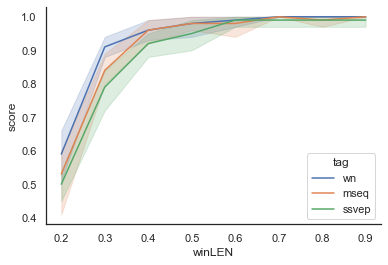

In [5]:
sns.set_theme(style='white')
sns.lineplot(data=scores[scores.subject == 'shinanlin'],
             x='winLEN', y='score', hue='tag')
sns.despine()

# _Image 7_ :Spectral

In [ ]:
spectral.head()
subAveSpec = spectral[['frequency','amplitude','remark','tag','subject']].groupby(by=['frequency','remark','tag','subject'],as_index=False).mean()
subAveSpec = subAveSpec[subAveSpec.remark!='resting']
subAveSpec.head()

In [ ]:
sub = 'shinanlin'
oneSub = subAveSpec[subAveSpec.subject==sub]


In [ ]:
plt.rcParams['text.usetex'] = True

f, axes = plt.subplots(figsize=(20, 5), ncols=3, nrows=1)

sns.set_theme(style='white')
plt.subplots_adjust(hspace=0.3)

for tag,ax in zip(oneSub.tag.unique(),axes):

    sns.lineplot(data=oneSub[(oneSub.tag==tag)&(oneSub.remark!='TR.F')],x='frequency',y='amplitude',hue='remark',ax=ax,linewidth=3)
    ax.set_title('STI type:%s'%tag)
    ax.set_xlabel('frequency(Hz)')
    ax.set_ylabel(r'amplitude(V**2)')

# plt.savefig('./results/pics/EEG-STI-spec.png', dpi=200, format='png')

In [ ]:
f, axes = plt.subplots(figsize=(5, 5), ncols=1, nrows=1)

sns.set_theme(style='white')
plt.subplots_adjust(hspace=0.3)

sns.lineplot(data=subAveSpec[(subAveSpec.remark=='TRF')&(subAveSpec.tag=='wn')],x='frequency',y='amplitude',hue='subject')

In [ ]:
specAve = spectral[spectral.subject=='shinanlin'][['frequency','amplitude','remark','tag','channel']].groupby(by=['frequency','amplitude','remark','tag'],as_index=False).mean()
specAve.head()

# _Fig 7_ :Group Analysis

In [ ]:
TRFs = []
add = 'results/exp-3'
subs = os.listdir(add)

for sub in subs:
    subFolder = add+os.sep+sub 
    f = pd.read_csv(subFolder+os.sep+'TRF.csv')
    TRFs.append(f)

TRFs = pd.concat(TRFs,ignore_index=True)
TRFs = TRFs[['channel','lags','trf','condition','subject']]
TRFs.head()

In [ ]:
subTRFs = TRFs[(TRFs.lags<0.4)&(TRFs.lags>0)].groupby(['lags','subject'],as_index=False).mean()
subTRFs.head()

In [ ]:
matrix = subTRFs.pivot_table(index='subject',columns='lags',values='trf')
Z = matrix.to_numpy()
index = matrix.index.to_numpy()
columns = matrix.columns.to_numpy()

In [ ]:
plt.rcParams['text.usetex'] = True

fig = plt.figure(figsize=(13, 10))

spec = fig.add_gridspec(4, 4)

ax1 = fig.add_subplot(spec[0, :])
ax2 = fig.add_subplot(spec[1:, :])

sns.lineplot(data=subTRFs, x='lags', y='trf',ax=ax1,linewidth=3)
plt.pcolormesh(columns, index, Z, cmap='vlag', shading='flat',linewidth=0.1,ax=ax2)

ax1.set_xlabel('')
ax1.set_ylabel('amplitude(a.u)')
ax1.set_title('Average TRFs across 55 subjects')

ax2.set_ylabel('subject')
ax2.set_xlabel('lags(s)')

plt.savefig('./results/pics/subjectTriggering.png', dpi=200, format='png')

In [ ]:
for sub in TRFs.subject.unique():

    f,ax = plt.subplots()
    subAve = TRFs[TRFs.subject==sub].groupby(['lags']).mean()
    sns.lineplot(data=subAve,x='lags',y='trf')
    plt.savefig('./results/pics/groups/sub%s.png'%sub, dpi=100, format='png')
    plt.close()

In [ ]:
subList = [30,43,48,7,16,20,23,27,39,41,47]
fig, axs = plt.subplots(ncols=2, nrows=len(subList), figsize=(10, 20))

sns.set_theme(style='white')

for subINX, sub in enumerate(subList):
    
    ax1, ax2 = axs[subINX]
    subAve = TRFs[TRFs.subject==sub].groupby(['lags']).mean()
    sns.lineplot(data=subAve,x='lags',y='trf',ax=ax1)
    ax1.vlines(x=0, ymin=-.5, ymax=.5, linestyles='dashed')
    ax1.set_xlabel('')
    ax1.set_ylabel('')

    s_ = subAve['trf'].to_numpy()
    f, t, Sxx = returnSpec(s_)
    ax2.pcolormesh(t-0.2, f, Sxx, shading='gouraud', cmap='vlag', alpha=0.7)

    ax2.set_ylim(0, 50)
    ax2.set_xlabel('')
    ax2.set_ylabel('')
plt.tight_layout()
plt.savefig('./results/pics/groupSSVEP.png', dpi=200, format='png')